In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

In [14]:
# df = pd.read_csv('../data/training_results.csv')
# df

In [15]:
# plot_df_1 = df[(df.n_way==50)&(df.n_class_additions==5)&(df.n_classes_start==5)&(df.algorithm=='FSCL')&(df.dataset=='flickr8k')].\
#     drop(columns=['Name']).groupby(['k_shot']).max().reset_index(drop=False)
# plot_df_2 = df[(df.n_way==10)&(df.n_class_additions==1)&(df.n_classes_start==2)&(df.algorithm=='FSCL')&(df.dataset=='google_commands')].\
#     drop(columns=['Name']).groupby(['k_shot']).max().reset_index(drop=False)
# plot_df = pd.concat([plot_df_1, plot_df_2])

# def rename_(name):
#     if name == 'flickr8k':
#         return 'Flickr8k: N=50, CA=5, CS=5'
#     else:
#         return "Google Commands: N=10, CA=2, CS=2"

# plot_df['dataset']=plot_df['dataset'].apply(rename_)
# plot_df.rename(columns={'k_shot':'K-Shot', 'validation_query_accuracy_epoch':'Final Accuracy', 'dataset':'Dataset'}, inplace=True)

# plt.figure(figsize=(20, 10))
# # set colours allowed to use to certain hex value
# sns.set_palette(sns.color_palette(["#1D2140", "#17C37B"])) 
# sns.barplot(x='K-Shot', y='Final Accuracy', hue='Dataset', data=plot_df)
# #add the value on top of the bar
# for p in plt.gca().patches:
#     plt.gca().text(p.get_x() + p.get_width()/2., p.get_height(), '{:1.2f}'.format(p.get_height()*100), fontsize=18, color='black', ha='center', va='bottom')

# # make the legend text bigger
# plt.legend(loc='lower right', prop={'size': 20})
# # make plot font size bigger
# plt.rcParams.update({'font.size': 22})

# # remove top grid line
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

# plt.savefig('k_shot_accuracy.png', transparent=True, pad_inches=.2, frameon=False)
# plt.show()

In [2]:
from src.models import WordClassificationAudio2DCnn, WordClassificationAudioCnnPool as WordClassificationAudioCnn, WordClassificationRnn
from src.losses import ClassificationLoss
from src.algorithms import FSCL, OML
from src.data.datasets import Flickr8kWordClassification, GoogleCommandsWordClassification
from src.data.samplers import SpokenWordTaskBatchSampler
from src.utils import flatten_dict

import torch.nn as nn
import torch

c:\Users\ruanv\miniconda3\envs\flickr2\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\ruanv\miniconda3\envs\flickr2\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [3]:
optim = {
'name': 'adam',
'inner_steps': 5,
'val_inner_steps': 5,
'gradient_clip_val': 0,
'inner_learning_rate': 0.001,
'outer_learning_rate': 0.0001,
'scheduler': False,
'scheduler_step': 30,
'scheduler_decay': 0.1,
}

encoder = WordClassificationAudio2DCnn(
    256, 
    64, 
    input_channels=39
)

class FSCLModel(nn.Module):
    def __init__(self, encoder, embedding_dim, n_classes):
        super().__init__()

        self.encoder = encoder

        def return_classification_layer(embedding_dim):
            layer = nn.Linear(embedding_dim, 1)
            torch.nn.init.xavier_uniform(layer.weight, )
            layer = nn.Sequential(
                nn.ReLU(),
                layer
            )
            return layer

        layers = [return_classification_layer(embedding_dim) for _ in range(n_classes)]
        self.classifiers = nn.ModuleList(layers)

    def forward(self, audio, total_classes_present):
        features = self.encoder(audio)
        layer_logits = []
        for c_layer in range(total_classes_present):
            layer_logits.append(self.classifiers[c_layer](features))
        logits = torch.cat(layer_logits, dim=1)
        return {'logits':logits}


loss_fn = ClassificationLoss()

model = FSCLModel(encoder, 256, 50)
algorithm = FSCL.load_from_checkpoint(
    './nway50_k5.ckpt', 
    model=model, 
    training_steps=5,
    intial_training_steps=30,
    n_classes_start=5,
    n_class_additions=5,
    loss_func=loss_fn,
    optim_config=optim,
    k_shot=5,
    quick_adapt=True
)
model = algorithm.model

C:\Users\ruanv\AppData\Local\Temp\ipykernel_12144\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


In [4]:
df = pd.read_csv('C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/flickr8k_word_splits_validation.csv')


In [25]:
import yaml

with open('../config/conversion_method/mfcc.yaml') as f:
    conv_config = yaml.safe_load(f) 

valiadation_dataset = Flickr8kWordClassification(
    meta_path='C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/flickr8k_word_splits_validation.csv',
    audio_root='C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/wavs/', 
    conversion_config=conv_config,
    stemming=True, 
    lemmetise=False          
)


def pad_audio(x, max_audio_len=101, pad_both_sides=False):
    import torch.nn.functional as F
    if x.size(-1) > max_audio_len:
        x = x[:,:max_audio_len]
    else:
        if pad_both_sides:
            pad_lenght = int(max_audio_len-x.size(-1))//2
            x = F.pad(x, (pad_lenght, pad_lenght+1 if int(max_audio_len-x.size(-1))%2!=0 else pad_lenght), 'constant', 0)
        else:
            x = F.pad(x, (0, int(max_audio_len-x.size(-1))), 'constant', 0)
    return x

df = pd.read_csv('C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/flickr8k_word_splits_validation.csv')
words_keep = [
'surf', 'wave', 'crowd', 'fight', 'togeth', 'ski',
'bridg', 'wood', 'teenag', 'lot', 'mud', 'pool', 'tabl', 'out',
'wet', 'footbal', 'make', 'team', 'shop', 'their', 'edg', 'guitar',
'across', 'area', 'do', 'trick', 'bike', 'obstacl', 'tri', 'rider',
'track', 'room', 'him', 'jacket', 'glass', 'open', 'them', 'cap',
'color', 'set', 'pant', 'wrestl', 'basketbal', 'climber', 'face',
'mountain', 'tent', 'shore', 'ground', 'bar'
]
df = df[df.stem.isin(words_keep)]

K = 20

# sample 5 instances of each stem
df = df.groupby('stem').apply(lambda x: x.sample(K)).reset_index(drop=True)
df.to_csv('./plot_data_words.csv', index=False)


valiadation_dataset = Flickr8kWordClassification(
    meta_path='plot_data_words.csv',
    audio_root='C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/wavs/', 
    conversion_config=conv_config,
    stemming=True, 
    lemmetise=False          
)

Loading audio: 100%|██████████| 2500/2500 [00:00<00:00, 279188.46it/s]


In [26]:
len(valiadation_dataset)

2500

In [27]:
N = 10
STEPS = K*N


groups = []
test_groups = []

for i in range(0, len(valiadation_dataset), STEPS):
    arrays = []
    labels = []

    for j in range(0+i, STEPS+i):
        arrays.append(pad_audio(torch.tensor(valiadation_dataset[j][0])).unsqueeze(0))
        labels.append(torch.tensor(valiadation_dataset[j][1]))
    
    arrays = torch.concat(arrays,dim=0)

    # take every 5th instance as test
    test_arrays = arrays[::5]
    test_labels = labels[::5]

    # skip every 5th instance
    arrays = torch.concat([array.unsqueeze(0) for i, array in enumerate(arrays) if i%5!=0 or i==0],dim=0)
    labels = [label for i, label in enumerate(labels) if i%5!=0 or i==0]

    groups.append({'data':arrays, 'labels':labels})
    test_groups.append({'data':test_arrays, 'labels':test_labels})

In [28]:
len(groups)

5

In [29]:
results = pd.DataFrame()

model = FSCLModel(encoder, 256, 50)
algorithm = FSCL.load_from_checkpoint(
    './nway50_k5.ckpt', 
    model=model, 
    training_steps=5,
    intial_training_steps=30,
    n_classes_start=5,
    n_class_additions=5,
    loss_func=loss_fn,
    optim_config=optim,
    k_shot=5,
    quick_adapt=True
)
model = algorithm.model

criterion = ClassificationLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
for n, group in enumerate(groups):
    model.train()
    data, labels = group['data'], group['labels']
    for i in range(50):
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data, (n+1)*N)
        outputs['labels'] = torch.tensor(labels)
        # Compute loss
        loss = criterion(outputs)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
            
    # Print loss for each epoch
    print(f'Training loss: {loss.item():.4f}')

    for group in groups[:n+1]:
        data, labels = group['data'], group['labels']
        optimizer.zero_grad()

        # take every 5th instance
        data = data[::5]
        labels = labels[::5]

        # Forward pass
        outputs = model(data, (n+1)*N)
        outputs['labels'] = torch.tensor(labels)
        # Compute loss
        loss = criterion(outputs)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()

        for i, group in enumerate(test_groups[:n+1]):
            data, labels = group['data'], group['labels']
            outputs = model(data, (i+1)*N)
            outputs['labels'] = torch.tensor(labels)
            loss = criterion(outputs)

            predicted_labels = torch.argmax(outputs['logits'], dim=1)
            accuracy = torch.sum(predicted_labels == torch.tensor(labels)).item() / len(labels)

            # print(f'Test loss for group {i}, after training group {n}: {loss.item():.4f}')
            # print(f'Test accuracy for group {i}, after training group {n}: {accuracy:.4f}') 
            # print('---')

            results = pd.concat([results,pd.DataFrame({'loss':[loss.item()], 'accuracy':[accuracy], 'group':[i], 'training_group':[n]})])
            results.to_csv('group_averages_MAMLCon_N10.csv', index=False)

    # print('*'*50)


C:\Users\ruanv\AppData\Local\Temp\ipykernel_12144\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.0064


KeyboardInterrupt: 

<AxesSubplot:xlabel='group', ylabel='accuracy'>

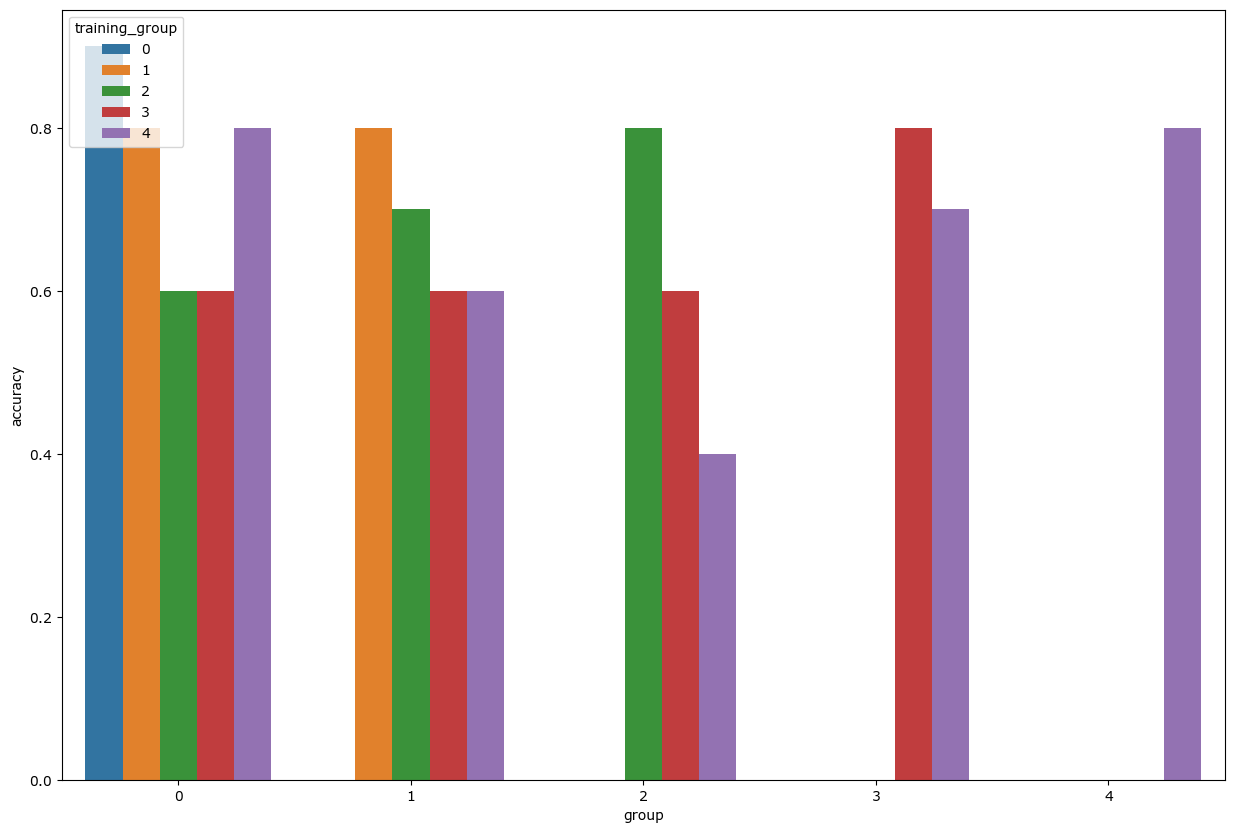

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(x='group', y='accuracy', hue='training_group', data=results)

In [23]:
t_model = FSCLModel(encoder, 256, 50)
results = pd.DataFrame()

criterion = ClassificationLoss()
optimizer = torch.optim.Adam(t_model.parameters(), lr=0.0001)

# Training loop
for n, group in enumerate(groups):
    t_model.train()
    data, labels = group['data'], group['labels']
    for i in range(50):
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = t_model(data, (n+1)*N)
        outputs['labels'] = torch.tensor(labels)
        # Compute loss
        loss = criterion(outputs)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
            
    # Print loss for each epoch
    print(f'Training loss: {loss.item():.4f}')

    # for group in groups[:n+1]:
    #     data, labels = group['data'], group['labels']
    #     optimizer.zero_grad()

    #     # take every 5th instance
    #     data = data[::5]
    #     labels = labels[::5]

    #     # Forward pass
    #     outputs = t_model(data, (n+1)*N)
    #     outputs['labels'] = torch.tensor(labels)
    #     # Compute loss
    #     loss = criterion(outputs)
        
    #     # Backward pass and optimization
    #     loss.backward()
    #     optimizer.step()

    with torch.no_grad():
        t_model.eval()

        for i, group in enumerate(test_groups[:n+1]):
            data, labels = group['data'], group['labels']
            outputs = t_model(data, (i+1)*N)
            outputs['labels'] = torch.tensor(labels)
            loss = criterion(outputs)

            predicted_labels = torch.argmax(outputs['logits'], dim=1)
            accuracy = torch.sum(predicted_labels == torch.tensor(labels)).item() / len(labels)

            # print(f'Test loss for group {i}, after training group {n}: {loss.item():.4f}')
            # print(f'Test accuracy for group {i}, after training group {n}: {accuracy:.4f}') 
            # print('---')

            results = pd.concat([results,pd.DataFrame({'loss':[loss.item()], 'accuracy':[accuracy], 'group':[i], 'training_group':[n]})])
            results.to_csv('group_averages_no_update_N10.csv', index=False)

C:\Users\ruanv\AppData\Local\Temp\ipykernel_17780\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.0008
Training loss: 0.0014
Training loss: 0.0016
Training loss: 0.0023
Training loss: 0.0029
